### Decision Tree ###

In [27]:
import pandas as pd

In [28]:
#df = pd.read_csv("../data/kickstarter_cleaned.csv")
#df = pd.read_csv("../data/kickstarter_one_hot_cleaned.csv")
#df = pd.read_csv("../data/kickstarter_final_data.csv")

df = pd.read_csv("../data/final.csv")

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#eliminate all non-numerical columns
df = df.select_dtypes(include=['number'])

#y is the target feature
y = df['SuccessfulBool']
#X consists of all features other than the target feature
X = df.drop('SuccessfulBool', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [32]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, f1_score
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#thresholds = np.arange()

def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):
    clf = DecisionTreeClassifier(random_state=42)
    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10)
    grid.fit(X_train, y_train)

    # Now get the best model
    best_model = grid.best_estimator_

    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    '''
    y_scores = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    '''
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }

              precision    recall  f1-score   support

           0       0.94      0.46      0.61      4384
           1       0.41      0.93      0.57      1806

    accuracy                           0.59      6190
   macro avg       0.68      0.69      0.59      6190
weighted avg       0.79      0.59      0.60      6190

Threshold: 0.10 -> F1 Score: 0.5725
              precision    recall  f1-score   support

           0       0.92      0.55      0.69      4384
           1       0.45      0.89      0.59      1806

    accuracy                           0.65      6190
   macro avg       0.68      0.72      0.64      6190
weighted avg       0.78      0.65      0.66      6190

Threshold: 0.20 -> F1 Score: 0.5947
              precision    recall  f1-score   support

           0       0.89      0.63      0.74      4384
           1       0.48      0.82      0.60      1806

    accuracy                           0.68      6190
   macro avg       0.68      0.72      0.67      6190
we

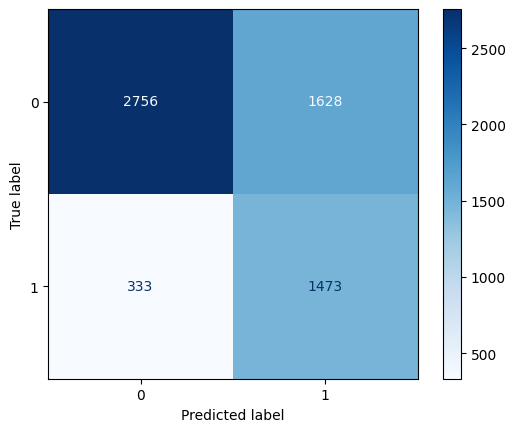

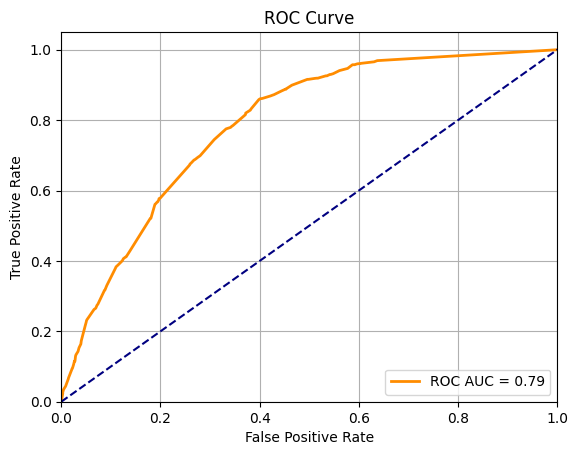

In [ ]:

decision_tree_param_grid = {
    'max_depth': range(5, 25),
    'min_samples_leaf': range(2, 15),
    'min_samples_split': range(10, 15)
}

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result = grid_search_roc_auc_tree(X, y, param_grid=decision_tree_param_grid, return_feature_importance=False, return_cv_scores=False)

'''top_model_cv_aucs = results_df.iloc[0]['cv_aucs']
print(top_model_cv_aucs)
print(results_df.iloc[0]['params'])'''

print(result)


#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result['fpr'], result['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


### Decision Tree Results ###

{'cv_accuracy': np.float64(0.7512807081444277), 'best_params': {'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 10}, 'best_thresh': {'thresh': np.float64(0.30000000000000004), 'f1': 0.6046808510638297}}

- Cross validation (10 fold) accuracy: 0.751
- Parameters: max_depth 8, min_samples_leaf: 14, min_samples_split: 10, threshold 0.3
- F1 score: 0.604

#### Confusion Matrix: ####

<pre>              precision    recall  f1-score   support

           0       0.87      0.71      0.78      4384
           1       0.51      0.73      0.60      1806

    accuracy                           0.71      6190
   macro avg       0.69      0.72      0.69      6190
weighted avg       0.76      0.71      0.73      6190</pre>

## Gradient Boost Decision Trees ##

Rerun the above tests but with Gradient Boost Classifier. Gradients of the loss function.

Initial run with:
`clf = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)`

results in a mean score of 0.7367 and AUC score of 0.81.

In [46]:
from sklearn.ensemble import GradientBoostingClassifier


def grid_search_roc_auc_gradient_boost_tree(X, y, param_grid, cv=10, random_state=42):
    #    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10)
    clf = GradientBoostingClassifier(random_state=random_state)
    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Now get the best model
    best_model = grid.best_estimator_

    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        #print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }

Threshold: 0.10 -> F1 Score: 0.5726
Threshold: 0.20 -> F1 Score: 0.6347
Threshold: 0.30 -> F1 Score: 0.6549
Threshold: 0.40 -> F1 Score: 0.6301
Threshold: 0.50 -> F1 Score: 0.5699
Threshold: 0.60 -> F1 Score: 0.4527
{'cv_accuracy': np.float64(0.7841710358577194), 'best_params': {'learning_rate': np.float64(0.08999999999999998), 'loss': 'log_loss', 'max_depth': 4, 'n_estimators': 100}, 'best_thresh': {'thresh': np.float64(0.30000000000000004), 'f1': 0.6549218233869192, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.91      0.72      0.80      4384\n           1       0.54      0.82      0.65      1806\n\n    accuracy                           0.75      6190\n   macro avg       0.73      0.77      0.73      6190\nweighted avg       0.80      0.75      0.76      6190\n', 'confusion_matrix': array([[3136, 1248],
       [ 319, 1487]])}, 'best_model': GradientBoostingClassifier(learning_rate=np.float64(0.08999999999999998),
           

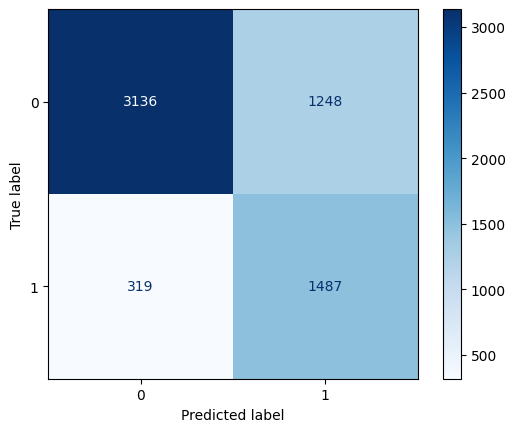

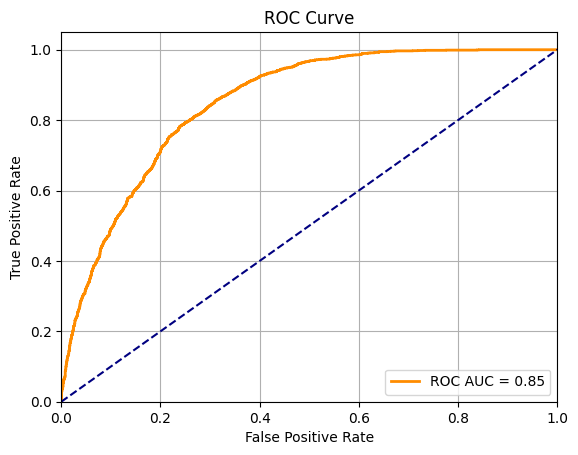

In [ ]:

gradient_boost_tree_param_grid = {
    'loss': ['log_loss'],#loss function. log_loss is the default
    'learning_rate': np.arange(0.08, 1.2, 0.02),
    'n_estimators': range(50, 400, 50),
    'max_depth': range(3, 5, 1),#smaller since there are many estimators.
    #'min_samples_leaf': range(10, 30, 5),
    #'min_samples_split': range(10, 15),
}

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result_gradient_boost = grid_search_roc_auc_gradient_boost_tree(X, y, param_grid=gradient_boost_tree_param_grid)

print(result_gradient_boost)


#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result_gradient_boost['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result_gradient_boost['fpr'], result_gradient_boost['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result_gradient_boost['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


### Adaboost ###

In [55]:
from sklearn.ensemble import AdaBoostClassifier


def grid_search_roc_auc_adaboost_tree(X, y, param_grid, cv=10, random_state=42):

    #basic learner decision tree
    dt = DecisionTreeClassifier(random_state=random_state)

    ada_boost = AdaBoostClassifier(estimator=dt, random_state=random_state)

    grid = GridSearchCV(ada_boost, param_grid, cv=10, n_jobs=-1, verbose=1)

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_


    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        #print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Threshold: 0.10 -> F1 Score: 0.4517
Threshold: 0.20 -> F1 Score: 0.5249
Threshold: 0.30 -> F1 Score: 0.5536
Threshold: 0.40 -> F1 Score: 0.6277
Threshold: 0.50 -> F1 Score: 0.5766
Threshold: 0.60 -> F1 Score: 0.1393
{'cv_accuracy': np.float64(0.7822313546569026), 'best_params': {'estimator__max_depth': 9, 'learning_rate': np.float64(0.2), 'n_estimators': 400}, 'best_thresh': {'thresh': np.float64(0.4), 'f1': 0.6276817922916271, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.94      0.59      0.72      4384\n           1       0.48      0.92      0.63      1806\n\n    accuracy                           0.68      6190\n   macro avg       0.71      0.75      0.68      6190\nweighted avg       0.81      0.68      0.70      6190\n', 'confusion_matrix': array([[2576, 1808],
       [ 153, 1653]])}, 'best_model': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=9

/Users/williamgreen/Documents/GitHub/kickstarter-project-success-predictions/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/williamgreen/Documents/GitHub/kickstarter-project-success-predictions/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/williamgreen/Documents/GitHub/kickstarter-project-success-predictions/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

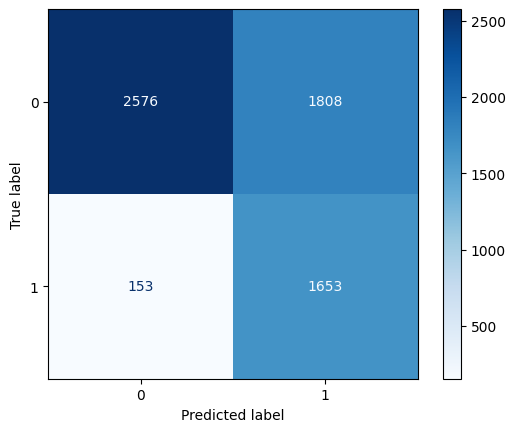

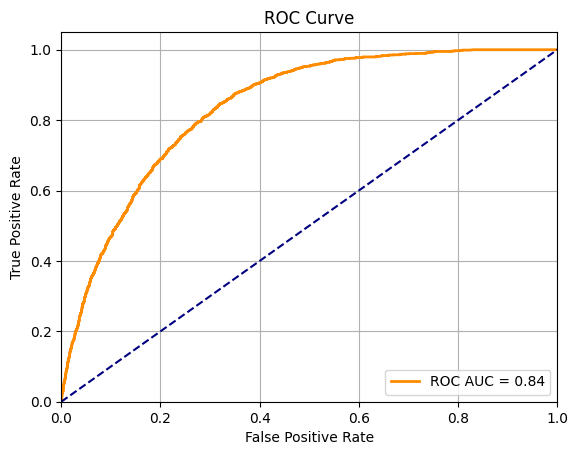

In [59]:
ada_boost_param_grid = {
    'estimator__max_depth': range(4, 10),  # Tuning the depth of the DecisionTree
    'n_estimators': [200, 400, 600],  # Number of estimators in AdaBoost
    'learning_rate': np.arange(0.2, 1.0, 0.2),  # Learning rate of AdaBoost
}

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result_ada_boost = grid_search_roc_auc_adaboost_tree(X, y, param_grid=ada_boost_param_grid)

print(result_ada_boost)


#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result_ada_boost['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result_ada_boost['fpr'], result_ada_boost['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result_ada_boost['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Old Gradient Boost Code ###

All of the ROC curves are visible here for the run iterations. I'll leave this here.

goal                           1.897847e-01
launch_to_state_change_days    1.209248e-01
category_grouped_Web           1.002870e-01
create_to_launch_days          1.002329e-01
category_grouped_Software      5.748679e-02
                                   ...     
currency_grouped_Other         1.586348e-04
currency_grouped_CAD           1.399351e-04
deadline_weekday_Saturday      8.469883e-05
deadline_weekday_Monday        3.918799e-05
country_grouped_GB             4.769679e-07
Length: 73, dtype: float64
depth 3 n_estimators 200 learning rate 0.12000000000000001 roc_auc 0.8492399877537163


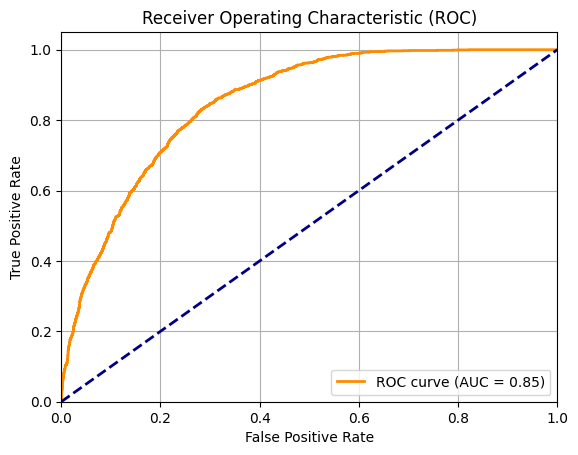

goal                           1.897847e-01
launch_to_state_change_days    1.209248e-01
category_grouped_Web           1.002870e-01
create_to_launch_days          1.002329e-01
category_grouped_Software      5.748679e-02
                                   ...     
currency_grouped_Other         1.586348e-04
currency_grouped_CAD           1.399351e-04
deadline_weekday_Saturday      8.469883e-05
deadline_weekday_Monday        3.918799e-05
country_grouped_GB             4.769679e-07
Length: 73, dtype: float64
depth 3 n_estimators 200 learning rate 0.14 roc_auc 0.8492399877537163


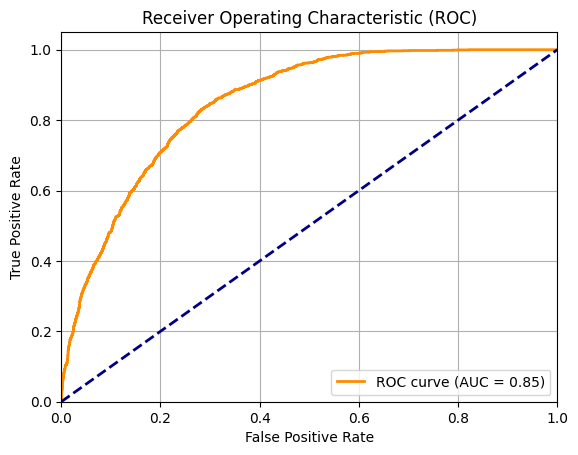

goal                           1.897847e-01
launch_to_state_change_days    1.209248e-01
category_grouped_Web           1.002870e-01
create_to_launch_days          1.002329e-01
category_grouped_Software      5.748679e-02
                                   ...     
currency_grouped_Other         1.586348e-04
currency_grouped_CAD           1.399351e-04
deadline_weekday_Saturday      8.469883e-05
deadline_weekday_Monday        3.918799e-05
country_grouped_GB             4.769679e-07
Length: 73, dtype: float64
depth 4 n_estimators 200 learning rate 0.12000000000000001 roc_auc 0.8492399877537163


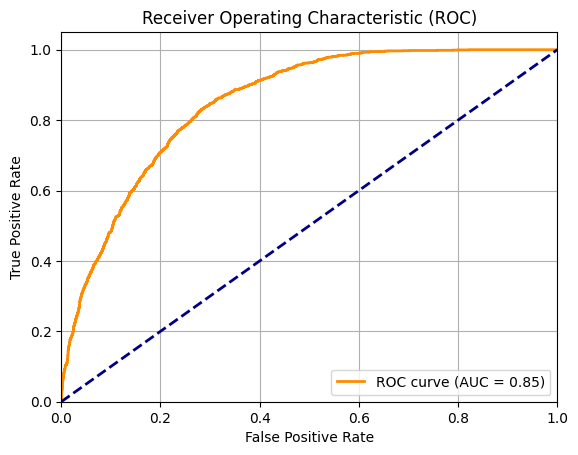

goal                           1.897847e-01
launch_to_state_change_days    1.209248e-01
category_grouped_Web           1.002870e-01
create_to_launch_days          1.002329e-01
category_grouped_Software      5.748679e-02
                                   ...     
currency_grouped_Other         1.586348e-04
currency_grouped_CAD           1.399351e-04
deadline_weekday_Saturday      8.469883e-05
deadline_weekday_Monday        3.918799e-05
country_grouped_GB             4.769679e-07
Length: 73, dtype: float64
depth 4 n_estimators 200 learning rate 0.14 roc_auc 0.8492399877537163


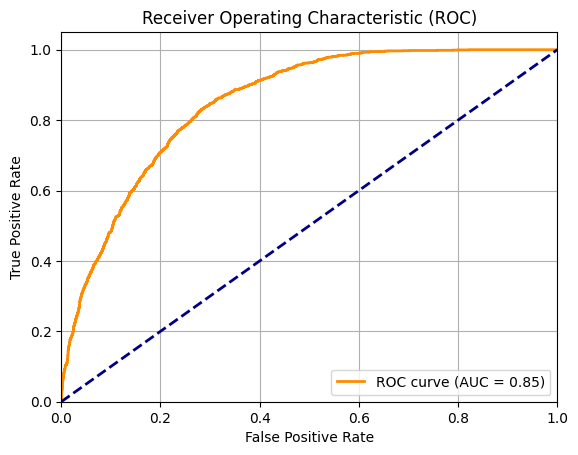

goal                           1.897847e-01
launch_to_state_change_days    1.209248e-01
category_grouped_Web           1.002870e-01
create_to_launch_days          1.002329e-01
category_grouped_Software      5.748679e-02
                                   ...     
currency_grouped_Other         1.586348e-04
currency_grouped_CAD           1.399351e-04
deadline_weekday_Saturday      8.469883e-05
deadline_weekday_Monday        3.918799e-05
country_grouped_GB             4.769679e-07
Length: 73, dtype: float64
depth 3 n_estimators 250 learning rate 0.12000000000000001 roc_auc 0.8492399877537163


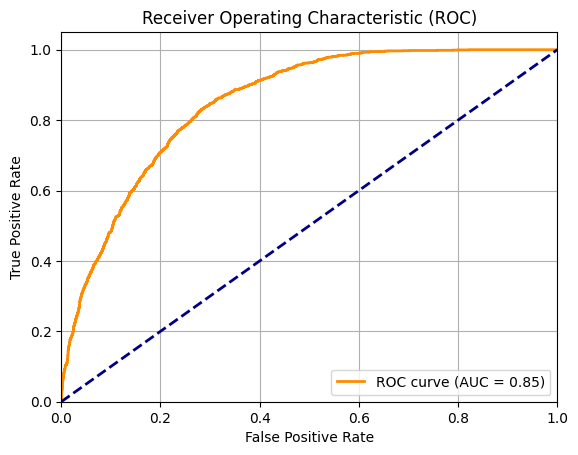

goal                           1.897847e-01
launch_to_state_change_days    1.209248e-01
category_grouped_Web           1.002870e-01
create_to_launch_days          1.002329e-01
category_grouped_Software      5.748679e-02
                                   ...     
currency_grouped_Other         1.586348e-04
currency_grouped_CAD           1.399351e-04
deadline_weekday_Saturday      8.469883e-05
deadline_weekday_Monday        3.918799e-05
country_grouped_GB             4.769679e-07
Length: 73, dtype: float64
depth 3 n_estimators 250 learning rate 0.14 roc_auc 0.8492399877537163


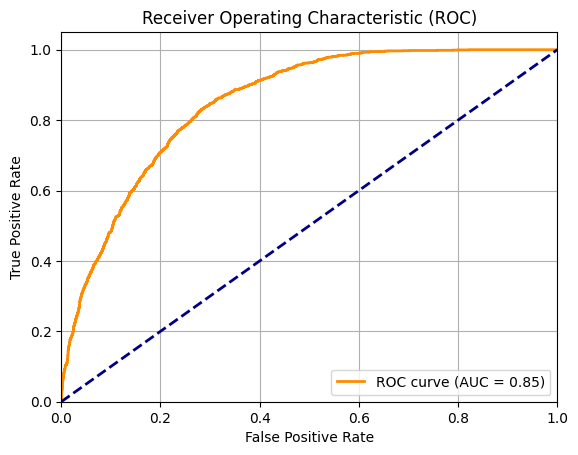

goal                           1.897847e-01
launch_to_state_change_days    1.209248e-01
category_grouped_Web           1.002870e-01
create_to_launch_days          1.002329e-01
category_grouped_Software      5.748679e-02
                                   ...     
currency_grouped_Other         1.586348e-04
currency_grouped_CAD           1.399351e-04
deadline_weekday_Saturday      8.469883e-05
deadline_weekday_Monday        3.918799e-05
country_grouped_GB             4.769679e-07
Length: 73, dtype: float64
depth 4 n_estimators 250 learning rate 0.12000000000000001 roc_auc 0.8492399877537163


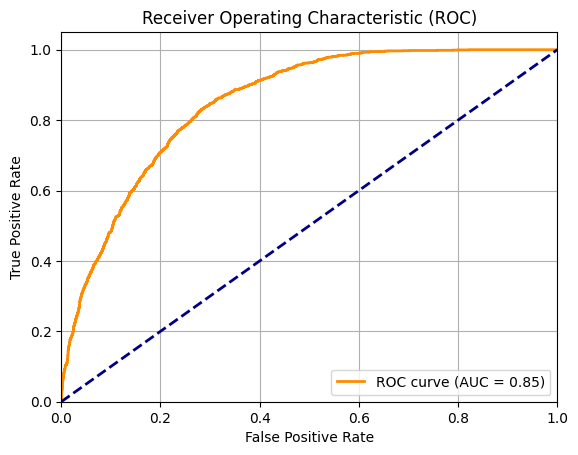

goal                           1.897847e-01
launch_to_state_change_days    1.209248e-01
category_grouped_Web           1.002870e-01
create_to_launch_days          1.002329e-01
category_grouped_Software      5.748679e-02
                                   ...     
currency_grouped_Other         1.586348e-04
currency_grouped_CAD           1.399351e-04
deadline_weekday_Saturday      8.469883e-05
deadline_weekday_Monday        3.918799e-05
country_grouped_GB             4.769679e-07
Length: 73, dtype: float64
depth 4 n_estimators 250 learning rate 0.14 roc_auc 0.8492399877537163


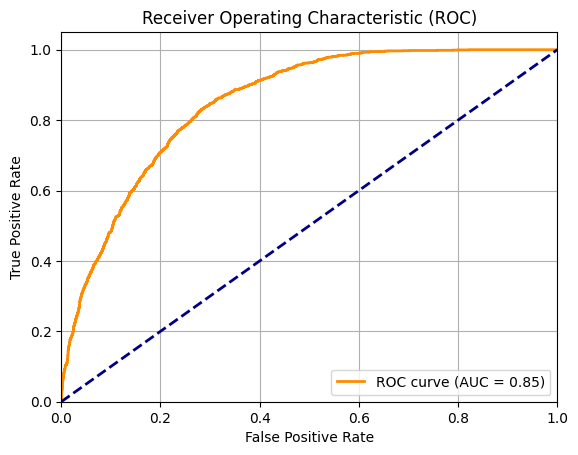

In [ ]:
#old. to-delete after the grid function is verified to work

from sklearn.ensemble import GradientBoostingClassifier

model_score_stats = []

for i in range(1, 3):
    n_estimators = 150 + i * 50
    for j in range(1, 3):
        max_depth = 2 + j
        for k in range(1, 3):
            learning_rate = 0.1 + k * 0.02
            clf_Adaboost = GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.15, random_state=42)
            clf_Adaboost.fit(X_train, y_train)

            cv_scores = cross_val_score(clf_Adaboost, X, y, cv=10)

            #examine the feature importance
            importances = clf_Adaboost.feature_importances_
            feature_ranks = pd.Series(importances, index=X.columns).sort_values(ascending=False)
            filtered_ranks = feature_ranks[feature_ranks > 0]
            print(filtered_ranks)
            #for index, value in zip(feature_ranks.index, feature_ranks.values):
            #    print(index, value)
            #print(feature_ranks)
            #split_feature_index = clf.tree_.feature[0]
            #print("Split on feature:", X.columns[split_feature_index])

            #model_score_stats.append({"model": clf_Adaboost, "depth": i, "min_sample_split":min_sample_split, "mean_score": cv_scores.mean(), "score_std":cv_scores.std()})

            #print(f"Cross-validation scores: {cv_scores}")
            #print(f"Mean accuracy: {cv_scores.mean():.4f}")
            #print(f"Standard deviation of accuracy: {cv_scores.std():.4f}")

            y_scores = clf_Adaboost.predict_proba(X_test)[:, 1]  # Get probability for the positive class

            # Compute ROC curve and AUC
            fpr, tpr, thresholds = roc_curve(y_test, y_scores)
            roc_auc = auc(fpr, tpr)

            print(f"depth {max_depth} n_estimators {n_estimators} learning rate {learning_rate} roc_auc {roc_auc}")
            model_score_stats.append({"model": clf, "max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate, "roc_auc": roc_auc})

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC)')
            plt.legend(loc='lower right')
            plt.grid()
            plt.show()

In [ ]:
#model_score_stats.append({"model": clf, "max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate, "roc_auc": roc_auc})

max_score = max(model_score_stats, key=lambda x: x['roc_auc'])
#min_std = min(model_score_stats, key=lambda x: x['score_std'])

print(f"maximum roc_auc score parameters {max_score}")
#print(f"minimum score standard deviation parameters {min_std}")


maximum roc_auc score parameters {'model': DecisionTreeClassifier(max_depth=9, min_samples_leaf=14, random_state=42), 'max_depth': 3, 'n_estimators': 200, 'learning_rate': 0.12000000000000001, 'roc_auc': np.float64(0.8492399877537163)}


### More old grad boost code ###

Best n_estimators: 350


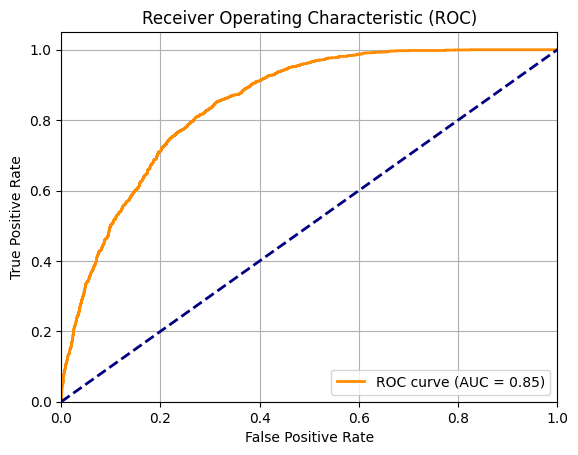

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [350]}
grid = GridSearchCV(GradientBoostingClassifier(learning_rate=0.15, max_depth=4), params, cv=10)
grid.fit(X_train, y_train)
print("Best n_estimators:", grid.best_params_['n_estimators'])

y_scores = grid.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)



plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Random Forest ##

In [63]:
from sklearn.ensemble import RandomForestClassifier


def grid_search_roc_auc_random_forest_tree(X, y, param_grid, cv=10, random_state=42):
    #    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10)
    clf = RandomForestClassifier(random_state=random_state)
    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    # Now get the best model
    best_model = grid.best_estimator_

    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        #print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }

Fitting 10 folds for each of 945 candidates, totalling 9450 fits
Threshold: 0.10 -> F1 Score: 0.5155
Threshold: 0.20 -> F1 Score: 0.5908
Threshold: 0.30 -> F1 Score: 0.6390
Threshold: 0.40 -> F1 Score: 0.6130
Threshold: 0.50 -> F1 Score: 0.4801
Threshold: 0.60 -> F1 Score: 0.2778
{'cv_accuracy': np.float64(0.7699083188758639), 'best_params': {'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 50}, 'best_thresh': {'thresh': np.float64(0.30000000000000004), 'f1': 0.6390006351894982, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.91      0.68      0.78      4384\n           1       0.52      0.84      0.64      1806\n\n    accuracy                           0.72      6190\n   macro avg       0.71      0.76      0.71      6190\nweighted avg       0.79      0.72      0.74      6190\n', 'confusion_matrix': array([[2976, 1408],
       [ 297, 1509]])}, 'best_model': RandomForestClassifier

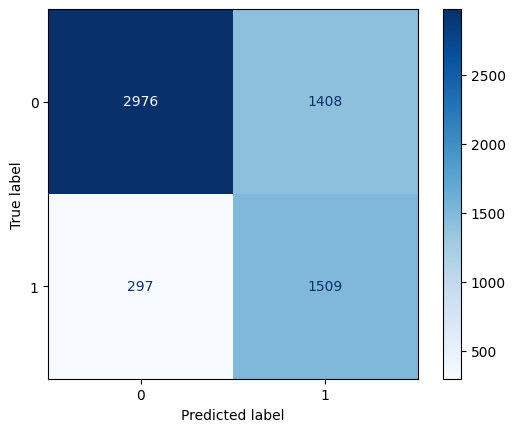

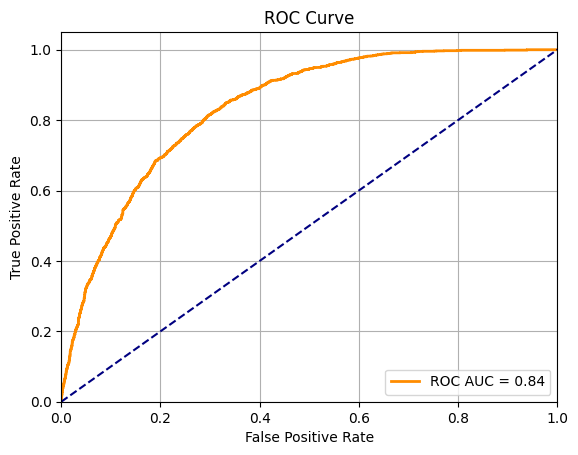

In [ ]:

random_forest_tree_param_grid = {
    'criterion': ['gini'],#split criterion. gini is default
    #'learning_rate': np.arange(0.01, 0.2, 0.02),
    'n_estimators': range(20, 50, 5),
    'min_samples_split': range(2, 15, 1),
    'max_depth': range(8, 20, 1),#smaller since there are many estimators.
    'min_samples_leaf': range(2, 7, 5),
    'min_samples_split': range(5, 8),
}

'''
ada_boost_param_grid = {
    'estimator__max_depth': range(4, 10),  # Tuning the depth of the DecisionTree
    'n_estimators': [200, 400, 600],  # Number of estimators in AdaBoost
    'learning_rate': np.arange(0.2, 1.0, 0.2),  # Learning rate of AdaBoost
}
'''

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result_random_forest = grid_search_roc_auc_random_forest_tree(X, y, param_grid=random_forest_tree_param_grid)

print(result_random_forest)


#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result_random_forest['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result_random_forest['fpr'], result_random_forest['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result_random_forest['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


Index(['goal', 'static_usd_rate', 'name_len_clean', 'blurb_len_clean',
       'deadline_month', 'deadline_day', 'deadline_hr', 'created_at_month',
       'created_at_day', 'created_at_hr', 'launched_at_month',
       'launched_at_day', 'launched_at_yr', 'launched_at_hr',
       'create_to_launch_days', 'launch_to_deadline_days',
       'launch_to_state_change_days', 'TOPCOUNTRY', 'LaunchedTuesday',
       'DeadlineWeekend', 'disable_communication', 'app', 'help', 'new',
       'world', 'canceled', 'country_grouped_CA', 'country_grouped_GB',
       'country_grouped_Other', 'country_grouped_US', 'currency_grouped_CAD',
       'currency_grouped_EUR', 'currency_grouped_GBP',
       'currency_grouped_Other', 'currency_grouped_USD',
       'deadline_weekday_Friday', 'deadline_weekday_Monday',
       'deadline_weekday_Saturday', 'deadline_weekday_Sunday',
       'deadline_weekday_Thursday', 'deadline_weekday_Tuesday',
       'deadline_weekday_Wednesday', 'state_changed_at_weekday_Friday',
   

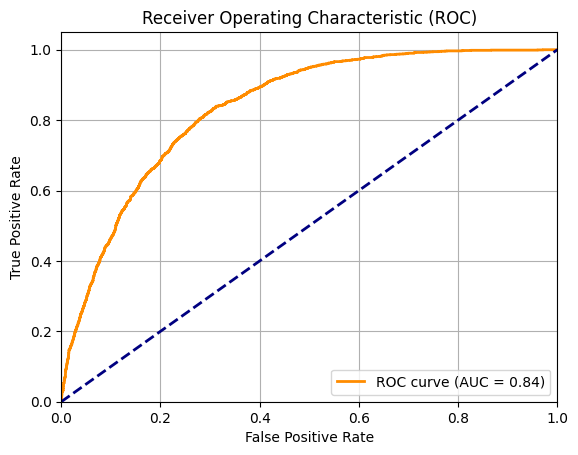

Feature ranking:
1. goal: 0.1883
2. category_grouped_Web: 0.1092
3. launch_to_state_change_days: 0.0978
4. create_to_launch_days: 0.0770
5. canceled: 0.0637
6. category_grouped_Software: 0.0483
7. launch_to_deadline_days: 0.0462
8. category_grouped_Other: 0.0352
9. launched_at_yr: 0.0335
10. category_grouped_Plays: 0.0319
11. launched_at_hr: 0.0264
12. name_len_clean: 0.0214
13. deadline_hr: 0.0213
14. created_at_hr: 0.0134
15. created_at_day: 0.0132
16. deadline_day: 0.0132
17. launched_at_day: 0.0127
18. category_grouped_Musical: 0.0117
19. deadline_month: 0.0110
20. launched_at_month: 0.0106
21. created_at_month: 0.0104
22. static_usd_rate: 0.0093
23. TOPCOUNTRY: 0.0089
24. category_grouped_Hardware: 0.0063
25. country_grouped_Other: 0.0054
26. new: 0.0051
27. launched_at_weekday_Tuesday: 0.0044
28. LaunchedTuesday: 0.0043
29. currency_grouped_USD: 0.0034
30. country_grouped_US: 0.0032
31. world: 0.0030
32. currency_grouped_EUR: 0.0029
33. blurb_len_clean: 0.0027
34. country_grouped

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

'''
22. static_usd_rate: 0.0098
23. category_grouped_Hardware: 0.0075
24. TOPCOUNTRY: 0.0074
25. new: 0.0052
26. LaunchedTuesday: 0.0044
27. launched_at_weekday_Tuesday: 0.0042
28. country_grouped_Other: 0.0041
29. category_grouped_Gadgets: 0.0036
30. currency_grouped_USD: 0.0034
31. country_grouped_US: 0.0030
32. DeadlineWeekend: 0.0028
33. world: 0.0026
34. disable_communication: 0.0024
35. currency_grouped_GBP: 0.0023
36. country_grouped_GB: 0.0023
37. launched_at_weekday_Friday: 0.0022
38. currency_grouped_EUR: 0.0020
39. created_at_weekday_Tuesday: 0.0019
40. deadline_weekday_Thursday: 0.0014
41. deadline_weekday_Friday: 0.0014
42. created_at_weekday_Monday: 0.0014
43. app: 0.0014
44. launched_at_weekday_Wednesday: 0.0014
45. launched_at_weekday_Thursday: 0.0012
46. created_at_weekday_Thursday: 0.0012
47. deadline_weekday_Saturday: 0.0012
48. help: 0.0012
49. launched_at_weekday_Monday: 0.0012
50. category_grouped_Apps: 0.0012
51. deadline_weekday_Tuesday: 0.0011
52. category_grouped_Sound: 0.0011
53. deadline_weekday_Sunday: 0.0010
54. deadline_weekday_Wednesday: 0.0010
55. created_at_weekday_Wednesday: 0.0009
56. category_grouped_Wearables: 0.0008
57. created_at_weekday_Friday: 0.0008
58. currency_grouped_CAD: 0.0007
59. country_grouped_CA: 0.0006
60. created_at_weekday_Saturday: 0.0006
61. created_at_weekday_Sunday: 0.0006
62. deadline_weekday_Monday: 0.0005
63. currency_grouped_Other: 0.0004
64. launched_at_weekday_Sunday: 0.0004
65. launched_at_weekday_Saturday: 0.0003
'''

print(X_train.columns)
#X_train.drop('name_len_clean', inplace=True, axis=1)
#X_test.drop('name_len_clean', inplace=True, axis=1)

rf = RandomForestClassifier(n_estimators=650, max_depth=25, random_state=42, min_samples_leaf=30)
rf.fit(X_train, y_train)

y_scores = rf.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

importances = rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# Print top features
print("Feature ranking:")
for i in range(len(feature_names)):
    print(f"{i + 1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")


Let's try it again but remove all the features with ranking of less than 0.01.

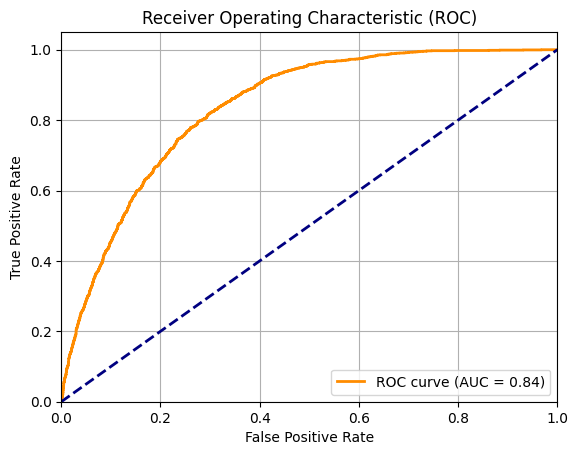

Feature ranking:
1. goal: 0.1931
2. launch_to_state_change_days: 0.1007
3. category_grouped_Web: 0.0993
4. create_to_launch_days: 0.0922
5. canceled: 0.0604
6. launch_to_deadline_days: 0.0497
7. category_grouped_Software: 0.0466
8. launched_at_yr: 0.0362
9. launched_at_hr: 0.0342
10. deadline_hr: 0.0313
11. category_grouped_Other: 0.0275
12. category_grouped_Plays: 0.0257
13. created_at_hr: 0.0254
14. created_at_day: 0.0254
15. deadline_day: 0.0242
16. launched_at_day: 0.0241
17. name_len_clean: 0.0226
18. deadline_month: 0.0179
19. created_at_month: 0.0177
20. launched_at_month: 0.0169
21. category_grouped_Musical: 0.0099
22. blurb_len_clean: 0.0042
23. state_changed_at_weekday_Thursday: 0.0032
24. state_changed_at_weekday_Friday: 0.0023
25. state_changed_at_weekday_Sunday: 0.0021
26. state_changed_at_weekday_Saturday: 0.0021
27. state_changed_at_weekday_Wednesday: 0.0021
28. state_changed_at_weekday_Monday: 0.0014
29. state_changed_at_weekday_Tuesday: 0.0013


In [ ]:
low_weight_features_drop = [
    "static_usd_rate",
    "category_grouped_Hardware",
    "TOPCOUNTRY",
    "new",
    "LaunchedTuesday",
    "launched_at_weekday_Tuesday",
    "country_grouped_Other",
    "category_grouped_Gadgets",
    "currency_grouped_USD",
    "country_grouped_US",
    "DeadlineWeekend",
    "world",
    "disable_communication",
    "currency_grouped_GBP",
    "country_grouped_GB",
    "launched_at_weekday_Friday",
    "currency_grouped_EUR",
    "created_at_weekday_Tuesday",
    "deadline_weekday_Thursday",
    "deadline_weekday_Friday",
    "created_at_weekday_Monday",
    "app",
    "launched_at_weekday_Wednesday",
    "launched_at_weekday_Thursday",
    "created_at_weekday_Thursday",
    "deadline_weekday_Saturday",
    "help",
    "launched_at_weekday_Monday",
    "category_grouped_Apps",
    "deadline_weekday_Tuesday",
    "category_grouped_Sound",
    "deadline_weekday_Sunday",
    "deadline_weekday_Wednesday",
    "created_at_weekday_Wednesday",
    "category_grouped_Wearables",
    "created_at_weekday_Friday",
    "currency_grouped_CAD",
    "country_grouped_CA",
    "created_at_weekday_Saturday",
    "created_at_weekday_Sunday",
    "deadline_weekday_Monday",
    "currency_grouped_Other",
    "launched_at_weekday_Sunday",
    "launched_at_weekday_Saturday"
]

try:
    X_train.drop(columns=low_weight_features_drop, axis=1, inplace=True)
    X_test.drop(columns=low_weight_features_drop, axis=1, inplace=True)
except:
    pass


rf = RandomForestClassifier(n_estimators=650, max_depth=20, random_state=42, min_samples_leaf=15)
rf.fit(X_train, y_train)

y_scores = rf.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

importances = rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# Print top features
print("Feature ranking:")
for i in range(len(feature_names)):
    print(f"{i + 1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
